In [94]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

import ast
from collections import Counter
from wordcloud import WordCloud
from itertools import chain
from transformers import pipeline

In [95]:
# Load graph
with open("data/Musicians_graph.pkl", "rb") as f:
    MusiciansG = pickle.load(f)

with open("data/groups_graph.pkl", "rb") as f:
    GroupsG = pickle.load(f)

### Groups Network

In [96]:
# Remove isolates
GroupsG.remove_nodes_from(list(nx.isolates(GroupsG)))
len(GroupsG.nodes)

398

In [97]:
def is_strong_community(G, community):
    for node in community:
        internal = sum(1 for neighbor in G.neighbors(node) if neighbor in community)
        external = sum(1 for neighbor in G.neighbors(node) if neighbor not in community)
        if internal <= external:
            return False
    return True

def is_weak_community(G, community):
    internal_total = 0
    external_total = 0
    for node in community:
        internal_total += sum(1 for neighbor in G.neighbors(node) if neighbor in community)
        external_total += sum(1 for neighbor in G.neighbors(node) if neighbor not in community)
    return internal_total > external_total

#### Plot giant component

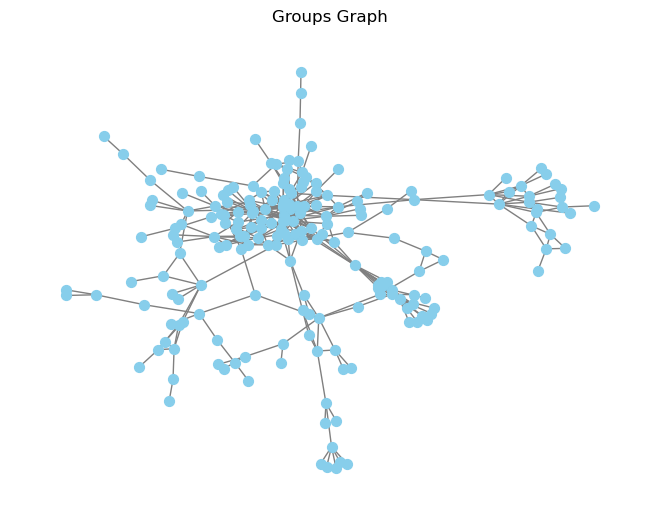

In [98]:
# Get the largest connected component
largest_cc_G = max(nx.connected_components(GroupsG), key=len)

# Create a subgraph of the largest component
G_largest_G = GroupsG.subgraph(largest_cc_G).copy()
nx.draw(G_largest_G, with_labels=False, node_color='skyblue', node_size=50, edge_color='gray')
plt.title("Groups Graph")
plt.show()

Plot with nodes coloured by degree

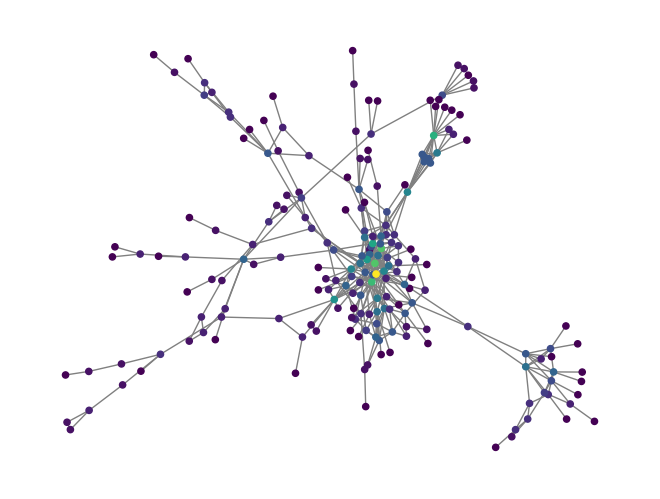

In [99]:
G = G_largest_G
# Compute node degrees
degrees = dict(G.degree())

# Extract degree values for coloring
node_colors = [degrees[node] for node in G.nodes()]

# Draw graph with nodes colored by degree
pos = nx.spring_layout(G, seed=42)  # layout for better visualization
nx.draw(
    G, pos,
    with_labels=False,
    node_color=node_colors,
    cmap=plt.cm.viridis,  # color map: you can try others like 'plasma', 'coolwarm'
    node_size=20,
    edge_color='gray',
    font_weight='bold'
)

# Add color bar
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm.set_array([])

#### most connected groups

In [100]:
dict_degree = dict(sorted([[band, degree] for band, degree in dict(GroupsG.degree()).items()], key=lambda x: int(x[1]), reverse=True))

In [101]:
nx.algorithms.community.modularity(GroupsG, [set(GroupsG.nodes) - {'Ache'}, {'Ache'}])

-1.623244866505105e-06

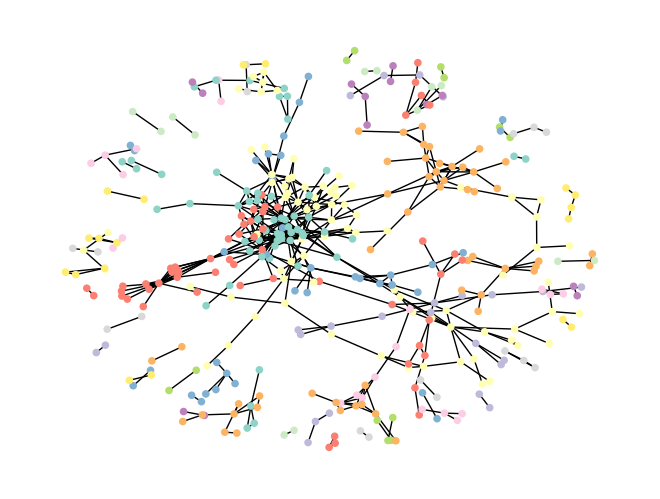

In [189]:
G = GroupsG
from community import community_louvain
partition = community_louvain.best_partition(G)

# Draw with community colors
pos = nx.spring_layout(G, k = 0.12, seed= 43)
colors = [partition[n] for n in G.nodes()]
nx.draw(G, pos, node_color=colors, node_size = 20, cmap=plt.cm.Set3)
plt.show()

In [186]:
[x[1] for x in sorted(Counter(partition.values()).items(), key= lambda x: x[1], reverse=True)]

[46,
 25,
 24,
 23,
 23,
 17,
 17,
 14,
 13,
 10,
 8,
 8,
 7,
 6,
 6,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [141]:
# Step 1: Get all biconnected components as sets of nodes
bicomponents = list(nx.biconnected_components(GroupsG))

# Step 2: Sort components by decreasing size
bicomponents.sort(key=lambda c: len(c), reverse=True)
#print("modularity total:", modularity(GroupsG, set(GroupsG.nodes())))
for i in range(10):
    if is_strong_community(GroupsG, bicomponents[i]):
        print(i,": Strong")
    elif is_weak_community(GroupsG, bicomponents[i]):
        print(i,": Weak")
    else:
        print(i, "None")
    #print(i, modularity(GroupsG, list(bicomponents[i])))
    

0 : Weak
1 : Weak
2 : Strong
3 : Weak
4 : Strong
5 : Strong
6 : Weak
7 : Strong
8 : Weak
9 : Weak


#### plot biconnected components

C:\Users\katin\AppData\Local\Temp\ipykernel_52900\2221113718.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(bicomp_edges))


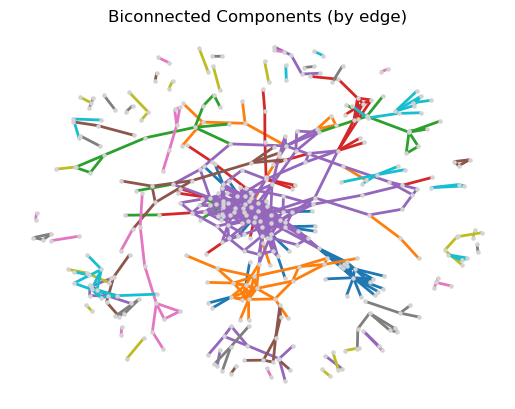

In [142]:
# Get biconnected components as edge sets
bicomp_edges = list(nx.biconnected_component_edges(GroupsG))

# Generate a color for each component
colors = plt.cm.get_cmap('tab10', len(bicomp_edges))

# Create a mapping of edges to colors
edge_color_map = {}
for idx, component in enumerate(bicomp_edges):
    for edge in component:
        edge_color_map[tuple(sorted(edge))] = colors(idx)

# Draw the graph
pos = nx.spring_layout(GroupsG, k=0.12, seed=41)  # consistent layout

# Draw all nodes
nx.draw_networkx_nodes(GroupsG, pos, node_color='lightgray', node_size=5)
#nx.draw_networkx_labels(G, pos)

# Draw edges with assigned colors
for edge, color in edge_color_map.items():
    nx.draw_networkx_edges(GroupsG, pos, edgelist=[edge], edge_color=[color], width=2)

plt.title("Biconnected Components (by edge)")
plt.axis('off')
plt.show()

In [143]:
articulation_points = list(nx.articulation_points(G))
print("Articulation (overlap) nodes:", articulation_points)

Articulation (overlap) nodes: ['Big Fat Snake', 'Dig og mig og solskin', 'Dream City', "Culpeper's Orchard", 'Kansas City Stompers', 'No Hope for the Kids', 'Gorilla Angreb', 'Day Of Phoenix', 'New Jungle Orchestra', 'Danser med Drenge', 'Esbjerg Ensemble', 'DR Symfoniorkestret', 'Musica Ficta', 'Det Jyske Ensemble', 'Århus Sinfonietta', 'Det Kongelige Kapel', 'Concerto Copenhagen', 'Sønderjyllands Symfoniorkester', 'The Baronets', 'Asinhell', 'Mellemblond (band)', 'Black City', 'HateSphere', 'Artillery', 'Dawn of Demise', 'Fenders', 'Skagarack', 'Swan Lee', 'Brats', 'King Diamond (band)', 'Pretty Maids', 'Grumpynators', 'Jackal', 'Mercenary', 'Invocator', 'The Arcane Order', 'Raunchy', 'På Slaget 12', 'Janes Rejoice', 'Rocazino', 'Backseat', 'Anne Linnet Band', 'Jackie Boo Flight', 'Spillemændene', 'Led Zeppelin Jam', 'Lone Kellermann og Rockbandet', 'Naïve', 'Voss Torp Brill', 'Scatterbrain', 'Escape Artists', 'Passport (band)', 'The Grenadines', 'Einstein (rockband)', 'Sir Henry & H

#### Assign nodes to biconnected clusters (store in dictionary)

In [144]:
# Step 1: Get all biconnected components as sets of nodes
bicomponents = list(nx.biconnected_components(GroupsG))

# Step 2: Sort components by decreasing size
bicomponents.sort(key=lambda c: len(c), reverse=True)

# Step 3: Assign nodes uniquely to clusters
node_to_cluster = {}
assigned_nodes = set()
cluster_id = 1

for component in bicomponents:
    # Get only the unassigned nodes in this component
    unassigned = component - assigned_nodes
    if unassigned:
        for node in unassigned:
            node_to_cluster[node] = cluster_id
        assigned_nodes.update(unassigned)
        cluster_id += 1

In [145]:
node_to_cluster

{'Bitch Boys': 1,
 'Dizzy Mizz Lizzy': 1,
 'Backseat': 1,
 'Saturnus (band)': 1,
 'Naïve': 1,
 'Sofamania': 1,
 'Anima (band)': 1,
 'Lone Kellermann og Rockbandet': 1,
 'Last Mile': 1,
 'Frede Fup': 1,
 'Røde Mor': 1,
 'Hvalsøspillemændene': 1,
 'Christianshavns Bluesband': 1,
 'Sedated Angel': 1,
 'Halberg Larsen': 1,
 'Cy, Maia & Robert': 1,
 'Charlatangruppen': 1,
 'Alpha Centauri': 1,
 'Big Fat Snake': 1,
 'Raunchy': 1,
 'Jomfru Ane Band': 1,
 'Tyggegummibanden': 1,
 'Kim Larsen & Bell*Star': 1,
 'Hos Anna': 1,
 'Naked Fish': 1,
 'Mo-I-Rana (band)': 1,
 'Secret Oyster': 1,
 'The Kandidate': 1,
 'The Antonelli Orchestra': 1,
 'Spillemændene': 1,
 'Danser med Drenge': 1,
 'Rockmaskinen (band)': 1,
 'Skullclub': 1,
 'Wolfkin': 1,
 'Janes Rejoice': 1,
 'TYG': 1,
 'Sønderjyllands Symfoniorkester': 1,
 'Escape Artists': 1,
 'Terje, Jesper & Joachim': 1,
 'New Jungle Orchestra': 1,
 'Anne Linnet Band': 1,
 'Dawn of Demise': 1,
 'Day Of Phoenix': 1,
 'Dr. Dopo Jam': 1,
 'Daisy (band)': 1,


### Text analysis

In [146]:
df_groups = pd.read_csv("data/groups_wMembers_Text.csv")[["title", "intro_text"]]

In [147]:
def clean_text(text):
    if not isinstance(text, str):
        return {}
    clean_text = re.sub(r'<.*?>', '', text)
    wordlist = [re.sub(r"[^a-zA-ZæøåÆØÅ]+", '', word.lower()) for word in clean_text.split() if re.sub(r"[^a-zA-Z]+", '', word.lower())]
    return wordlist

In [148]:
df_groups["textlist"] = df_groups["intro_text"].apply(clean_text)

In [149]:
#df_groups[["title", "textlist"]].to_csv("data/groups_cleantext.csv", index = False) 

In [150]:
def group2comfunc(group):
    try:
        return partition[group]
    except:
        return None

df_groups["community"] = df_groups["title"].apply(group2comfunc)
df_groups = df_groups.dropna(subset=['community'])
df_groups = df_groups.reset_index(drop=True)

In [151]:
with open("data/da_DK.dic", encoding="utf-8") as f:
    danish_words = set()
    for line in f:
        word = line.strip().split("/")[0]  # Remove affixes
        danish_words.add(word.lower())

print(f"Loaded {len(danish_words)} Danish words.")

Loaded 152366 Danish words.


In [152]:
for letter in "abcdefghjklmnopqrstuvxyzæ":
    if letter in danish_words:
        danish_words.remove(letter)

In [153]:
com_members = df_groups.groupby('community')['title'].apply(
    lambda x: [band for band in x])

In [154]:
from nltk.corpus import stopwords
stop_words = stopwords.words('danish')

In [155]:
member_names = list(pd.read_csv("data/musicians_wMembers.csv")["name"].apply(lambda x: str(x).split()))
member_names = [name.lower() for person in member_names for name in person]

In [156]:
group_names = list(df_groups["title"].apply(lambda x: x.split()))
group_names = [word.lower() for groupname in group_names for word in groupname]

In [157]:
def filter_text(word_lists, danish_words): #to only include words from danish dictionary, and not stop words
    all_words = chain.from_iterable(word_lists)
    return [word for word in all_words if (word in danish_words) and (word not in stop_words) and (word not in member_names) and (word not in group_names)]

com_words = df_groups.groupby('community')['textlist'].apply(
    lambda x: filter_text(x, danish_words)
)

In [158]:
communities = pd.DataFrame({
    'community': range(1, len(com_members) + 1),
    'groups': list(com_members),
    'com_words': list(com_words) })

#### Sentiment Analysis

In [159]:
# Load the lexicon
lexicon = pd.read_csv("data/AFINN-da-32.txt", sep="\t", header=None, names=["word", "score"])

# Turn into dictionary for fast lookup
sentiment_dict = dict(zip(lexicon.word, lexicon.score))

In [160]:
communities["scores"] = communities["com_words"].apply(lambda words: sum(sentiment_dict.get(word, 0) for word in words)/len(words))

In [161]:
communities["scores"][:10]

0    0.027356
1    0.045455
2    0.102041
3   -0.010870
4    0.037037
5    0.000000
6    0.146341
7    0.104575
8    0.004310
9    0.037383
Name: scores, dtype: float64

In [162]:
df_genres = pd.read_csv("data/groups_wMembers_Text_Genres.csv")[["title", "genres"]]
dict_genres = df_genres.set_index('title')['genres'].apply(lambda x: ast.literal_eval(x)).to_dict()

In [163]:
communities["genres"] = communities["groups"].apply(lambda x: [genre for group in x for genre in dict_genres[group]])

In [164]:
communities

,community,groups,com_words,scores,genres
0,1,"[Ache, The Broken Beats, Charlatangruppen, Cul...","[dansk, rockgruppe, dannet, bestod, januar, ju...",0.027356,"[rock, pop, rock, pop, rock, rock, rock, blues..."
1,2,"[ADS (band), UCR, Port Friendly, ADS (band), M...","[se, se, artikler, begynder, dansk, punkband, ...",0.045455,"[punk, pop, rock, punk, post-punk, rock, indie..."
2,3,"[The Alligators, Frank Rubino, The Alligators,...","[dansk, musikgruppe, dansk, musikgruppe, danne...",0.102041,"[rock, rock]"
3,4,"[Alrune Rod, Free To Choose]","[dansk, spillede, dannet, sonet, navn, blot, d...",-0.010870,"[rock, rock]"
4,5,"[Among Relatives, The Pockets, Darling Don't D...","[dansk, rockband, etableret, debutalbum, sveri...",0.037037,"[rock, rock, rock, rock, alternative rock, sho..."
...,...,...,...,...,...
70,71,"[Sunstroke PM, By the Patient, ORM (band)]","[debutalbum, livealbum, optaget, maj, dansk, s...",-0.066667,"[funk, heavy metal, death metal, heavy metal, ..."
71,72,"[Super Karla, Søsterrock]","[forveksle, aarhusiansk, aktivt, ligesom, shit...",-0.038760,"[pop, rock, rock]"
72,73,"[Kinski, Sund Fornuft (musikgruppe)]","[dansk, dannet, bestående, rap, rap, word, scr...",0.000000,"[soul, hip hop, hip hop]"
73,74,"[200 (rockgruppe), Mold, Yggdrasil (band)]","[færøsk, skarp, satirisk, tunge, færøerne, løs...",0.025862,"[rock, alternative rock, punk, rock, rock, jaz..."


In [165]:
def freq(wordlist):
    word_counts = Counter(wordlist)
    total = sum(word_counts.values())
    word_freq = {word: round(count / total,3) for word, count in word_counts.items()}
    sorted_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))
    return sorted_freq

communities["genrecount"] = communities["genres"].apply(freq)
communities["genrecount"][3]

{'rock': 1.0}

#### IDF

In [166]:
all_words = []
for com in com_words:
    all_words.extend(com)
word_counts = Counter(all_words)
unique_words = list(word_counts.keys())

def IDF(words):
    N = len(com_words)
    DF_dict = {word: 0 for word in words}

    for com in com_words:
        com_set = set(com)
        for word in words: 
            if word in com_set:
                DF_dict[word] +=1

    IDF_dict = {word: float(np.log(N/DF_dict[word])) for word in words}    
    return IDF_dict

IDF_dict = IDF(unique_words)

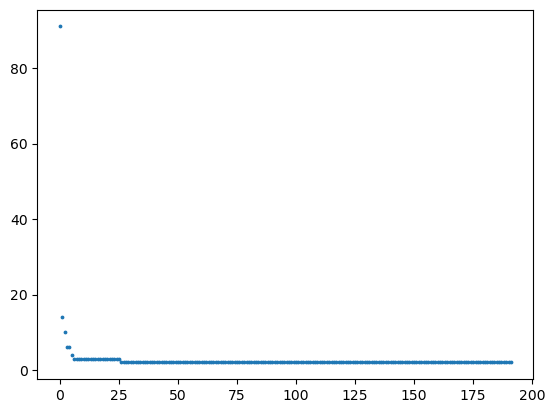

In [167]:
plt.scatter(list(range(len(bicomponents))), [len(c) for c in bicomponents], s = 3)

In [168]:
partition.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 33, 10, 19, 19, 12, 33, 19, 14, 6, 24, 16, 0, 17, 0, 19, 17, 18, 19, 0, 12, 19, 20, 21, 7, 16, 22, 0, 0, 23, 24, 19, 25, 26, 27, 0, 26, 33, 17, 19, 2, 0, 3, 26, 24, 12, 26, 28, 26, 10, 30, 0, 0, 31, 27, 24, 7, 0, 32, 33, 34, 33, 0, 0, 0, 19, 35, 36, 12, 12, 37, 12, 0, 38, 26, 38, 39, 24, 12, 0, 8, 40, 26, 31, 4, 0, 41, 42, 33, 12, 43, 0, 32, 0, 26, 12, 44, 26, 43, 0, 20, 26, 33, 0, 33, 8, 19, 7, 0, 0, 0, 24, 24, 33, 35, 24, 45, 10, 0, 1, 33, 26, 23, 46, 33, 0, 0, 12, 20, 12, 12, 33, 34, 47, 0, 48, 23, 34, 48, 23, 49, 45, 12, 48, 50, 51, 12, 12, 45, 25, 12, 0, 12, 19, 23, 4, 52, 0, 22, 26, 53, 34, 19, 23, 33, 19, 54, 43, 55, 56, 57, 41, 34, 12, 58, 35, 0, 0, 34, 46, 49, 26, 45, 20, 12, 59, 12, 26, 45, 33, 50, 12, 60, 61, 59, 33, 44, 14, 23, 0, 4, 0, 62, 62, 63, 33, 0, 0, 0, 64, 26, 65, 57, 26, 35, 60, 66, 40, 7, 67, 10, 21, 33, 39, 21, 35, 20, 30, 0, 14, 12, 20, 58, 7, 68, 51, 35, 12, 7, 45, 20, 36, 1, 24, 0, 51, 59, 64, 37, 19, 10, 33, 17, 19, 26

In [169]:
[len(c) for c in bicomponents]

[91,
 14,
 10,
 6,
 6,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

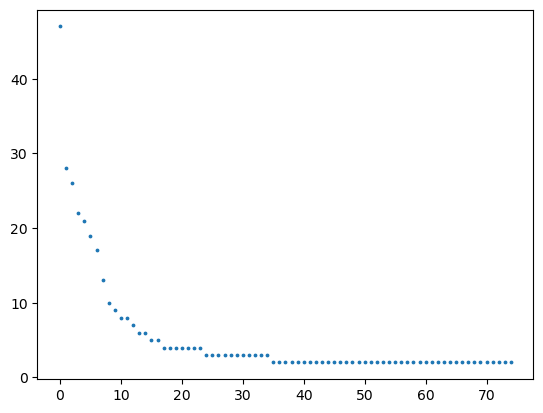

In [170]:
plt.scatter(list(range(len(Counter(partition.values())))), [x[1] for x in sorted(Counter(partition.values()).items(), key= lambda x: x[1], reverse=True)], s = 3)

In [171]:
sorted_communities = [x[0] for x in sorted(Counter(partition.values()).items(), key= lambda x: x[1], reverse=True)]

In [172]:
for com in sorted_communities[:10]:
    words = communities["com_words"][com] # getting the wordlist for the given community
    TF = Counter(words) # creating dictionary of counts
    TF_IDF = {word: TF[word] * IDF_dict[word] for word in words}
    most_TFIDF_words = Counter(TF_IDF).most_common(20)
    top_groups = sorted({group: dict_degree[group] for group in communities["groups"][com]}.items(), key = lambda x: x[1], reverse = True)
    print("--------------------------------")
    print(f"Community {com}")
    print(f"groups in community: {len(communities['groups'][com])}")
    print(f"top 5 groups, by degree: {[x[0] for x in top_groups[:5]]}")
    print(f"top genres: {list(communities['genrecount'][com].keys())[:3]}")
    print(f"sentiment scores: {communities['scores'][com]}")
    print(f"Top TF-IDF words: {', '.join(np.asarray(most_TFIDF_words)[:,0])}")

--------------------------------
Community 0
groups in community: 49
top 5 groups, by degree: ['Kansas City Stompers', 'Frede Fup', 'Lone Kellermann og Rockbandet', 'Delta Cross Band', 'Starfuckers']
top genres: ['rock', 'pop', 'blues']
sentiment scores: 0.02735562310030395
Top TF-IDF words: år, solgt, bestod, kor, spillede, sang, succes, kort, siden, bas, navn, kom, skrevet, først, guitarist, første, sanger, opstod, person, dylan
--------------------------------
Community 12
groups in community: 31
top 5 groups, by degree: ['New Jungle Orchestra', 'Hos Anna', 'Danser med Drenge', 'Anima (band)', 'The Lejrbåls']
top genres: ['rock', 'pop', 'jazz']
sentiment scores: 0.027198549410698096
Top TF-IDF words: guitarist, bestod, sanger, navn, sangerinde, slags, engang, side, første, år, aldrig, amerikanske, arbejde, fløjte, spillede, især, gav, uden, tilbage, aktivt
--------------------------------
Community 33
groups in community: 30
top 5 groups, by degree: ['HateSphere', 'Raunchy', 'The Cl

### Musicians

In [173]:
# Get the largest connected component
largest_cc_M = max(nx.connected_components(MusiciansG), key=len)

# Create a subgraph of the largest component
G_largest_M = MusiciansG.subgraph(largest_cc_M).copy()

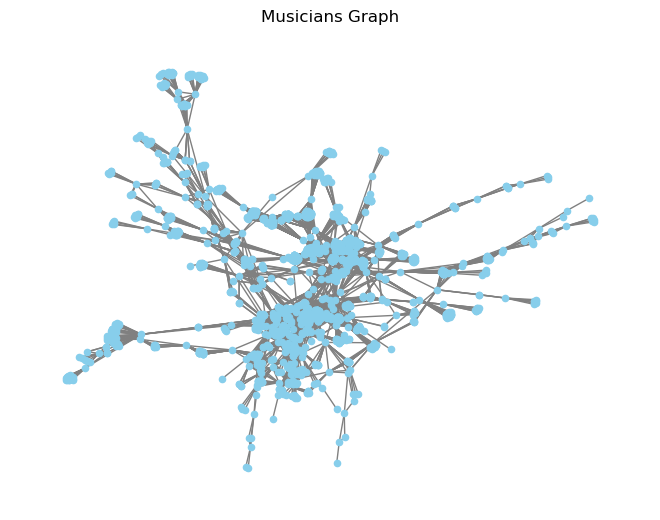

In [174]:
nx.draw(G_largest_M, with_labels=False, node_color='skyblue', node_size=20, edge_color='gray')
plt.title("Musicians Graph")
plt.show()